<h1><center>Ticket Price dataset</center></h1>
<h3><center>Our case is to predict the price of plane ticket</center></h3>

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize': [8, 4]}, font_scale=1.3)
%pip install -q datasist
from datasist.structdata import detect_outliers
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from category_encoders.binary import BinaryEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


# Read data

In [2]:
df = pd.read_excel('../input/reg-data/Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


# Business case
### Weekend in India is on Sunday only.
### In India , National holidays vary according to its local state  but there’re ones which applied over the whole country like:
  - 26 January -> Republic Day
  - 15 August -> Independence Day
  - 2 October -> Gandhi Jayanti

### change date to day and month and year to be able to add new column has holidays

In [4]:
def date_process(df):
    # change type of date
    df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y')
    # extract year, month, day and day_name from date
    df['year'] = df['Date_of_Journey'].dt.year
    df['month'] = df['Date_of_Journey'].dt.month
    df['day_name'] = df['Date_of_Journey'].dt.day_name()
    df['day'] = df['Date_of_Journey'].dt.day
    # drop date_of_jpurney
    df.drop('Date_of_Journey', axis=1, inplace=True)
    return df

In [5]:
df = date_process(df)

In [6]:
# add holiday column
conditions = [(df['day_name'] == 'Sunday'), (df['month'] == 1) & (df['day'] == 26), (df['month'] == 8) & (df['day'] == 15), (df['month'] == 10) & (df['day'] == 2)]
value = [1, 1, 1, 1]
df['holiday'] = np.select(conditions, value)

In [7]:
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day_name,day,holiday
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,2019,3,Sunday,24,1
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,2019,5,Wednesday,1,0
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,2019,6,Sunday,9,1
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,2019,5,Sunday,12,1
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,2019,3,Friday,1,0


# EDA

In [8]:
# see unique values in additional info
df['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

- Notice 'No info' and 'No Info' so let's convert all object columns into lower case

### Convert string columns into lower case 

In [9]:
def to_lower(df):
  string_cols = ['Airline', 'Source', 'Destination', 'Dep_Time', 'Arrival_Time', 'Duration', 'Additional_Info']
  for i in string_cols:
    df[i] = df[i].apply(lambda s: s.lower())
  return df

In [10]:
df = to_lower(df)

In [11]:
# check value counts in Airline
df['Airline'].value_counts()

jet airways                          3849
indigo                               2053
air india                            1752
multiple carriers                    1196
spicejet                              818
vistara                               479
air asia                              319
goair                                 194
multiple carriers premium economy      13
jet airways business                    6
vistara premium economy                 3
trujet                                  1
Name: Airline, dtype: int64

## Define some functions for ploting

In [12]:
# sub plots
def subplots(x,y):
    fig, axis = plt.subplots(x, y, figsize=(20,10))
    fig.tight_layout() # to fit
    plt.xticks(rotation=45);
    return axis

In [13]:
# to show precent of count in each category
def get_count_precent(ax):
  for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()-0., height, '{:1.2f}%'.format((height/len(df))*100), ha="center", fontsize=15)

In [14]:
# count plot
def count_plot(features, df):
  axis = subplots(2, 3)
  index = 0
  for i in range(2):
      for j in range(3):
        if index == len(features):
          break
        ax = sns.countplot(ax=axis[i][j],x=features[index],data=df)
        get_count_precent(ax)
        index += 1

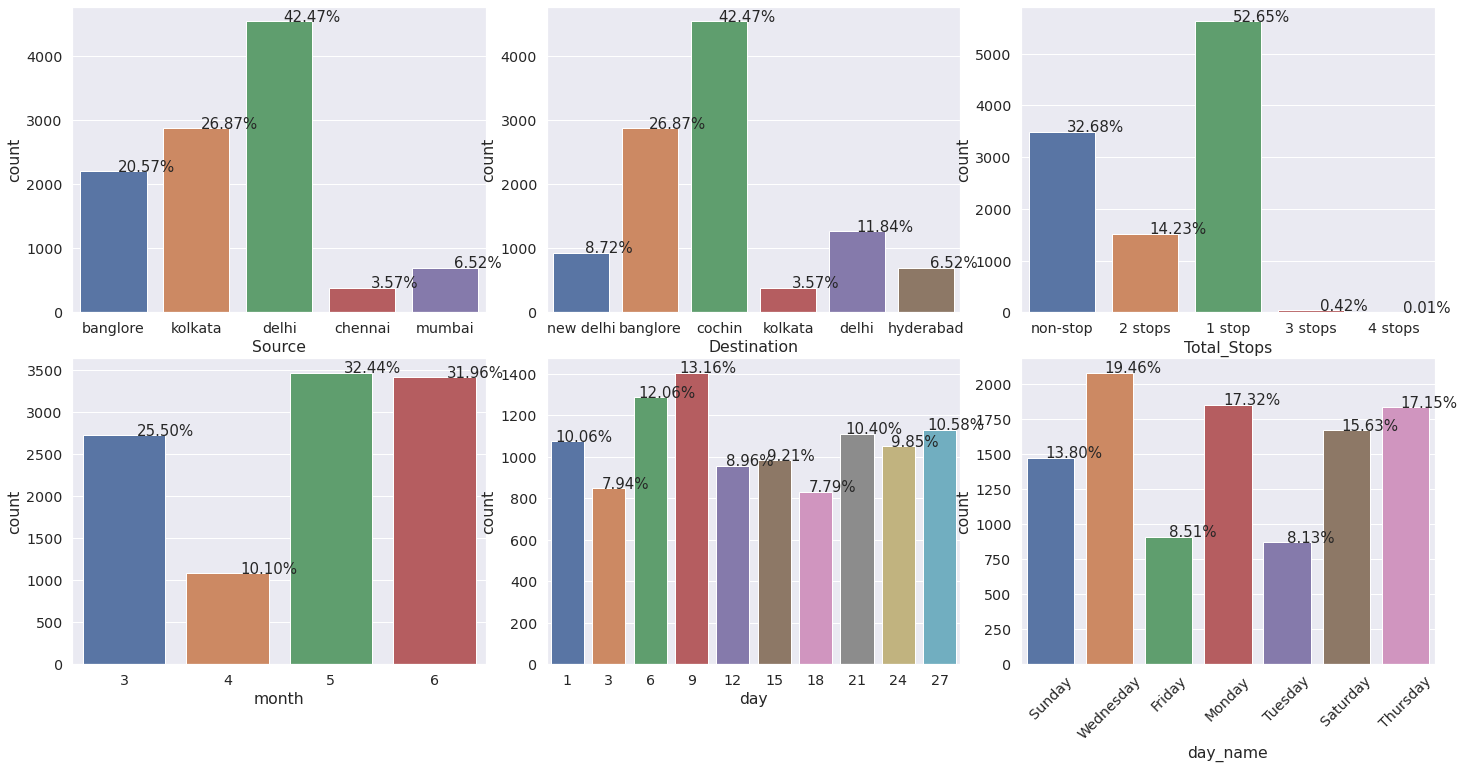

In [15]:
categorical_features = ['Source', 'Destination','Total_Stops','month','day', 'day_name']
count_plot(categorical_features, df)

In [16]:
df['Additional_Info'].value_counts()

no info                         8348
in-flight meal not included     1982
no check-in baggage included     320
1 long layover                    19
change airports                    7
business class                     4
1 short layover                    1
red-eye flight                     1
2 long layover                     1
Name: Additional_Info, dtype: int64

# Preprocessing

In [17]:
new_df = df.copy()

In [18]:
new_df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day_name,day,holiday
0,indigo,banglore,new delhi,BLR → DEL,22:20,01:10 22 mar,2h 50m,non-stop,no info,3897,2019,3,Sunday,24,1
1,air india,kolkata,banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,no info,7662,2019,5,Wednesday,1,0
2,jet airways,delhi,cochin,DEL → LKO → BOM → COK,09:25,04:25 10 jun,19h,2 stops,no info,13882,2019,6,Sunday,9,1
3,indigo,kolkata,banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,no info,6218,2019,5,Sunday,12,1
4,indigo,banglore,new delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,no info,13302,2019,3,Friday,1,0


## Check Null values

In [19]:
new_df.isnull().sum()

Airline            0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
year               0
month              0
day_name           0
day                0
holiday            0
dtype: int64

In [20]:
# drop null values
new_df.dropna(axis=0, subset=['Total_Stops', 'Route'], inplace=True)
# reset indexes
new_df.reset_index(inplace=True)
new_df.drop(['index'], axis=1, inplace=True)

## split Arrival time into hour and minutes,  day and month to check if the arrival date not before dept date

In [21]:
def split_arrival_time(df):
    df['Arrival_day'] = df['Arrival_Time'].str.split(' ').str[1]
    df['Arrival_month'] = df['Arrival_Time'].str.split(' ').str[2]
    df['Arrival_Time'] = df['Arrival_Time'].str.split(' ').str[0]
    df['Arrival_hour'] = df['Arrival_Time'].str.split(':').str[0].astype('int')
    df['Arrival_Minute'] = df['Arrival_Time'].str.split(':').str[1].astype('int')
    df.drop('Arrival_Time',axis=1,inplace=True)
    return df

In [22]:
new_df = split_arrival_time(new_df)

### not all rows have arrival day and month so let's take who have

In [23]:
data_with_arrival_day = new_df[~new_df['Arrival_day'].isnull()]

In [24]:
# see unique months
data_with_arrival_day.Arrival_month.unique()

array(['mar', 'jun', 'may', 'apr'], dtype=object)

In [25]:
# map to convert month name into number
month = {'mar':3, 'jun':6, 'may':5, 'apr':4}

data_with_arrival_day['Arrival_month'] = data_with_arrival_day['Arrival_month'].apply(lambda x: month[x]).astype('int')

In [26]:
len(data_with_arrival_day)

4334

In [27]:
data_with_arrival_day.head()

,Airline,Source,Destination,Route,Dep_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day_name,day,holiday,Arrival_day,Arrival_month,Arrival_hour,Arrival_Minute
0,indigo,banglore,new delhi,BLR → DEL,22:20,2h 50m,non-stop,no info,3897,2019,3,Sunday,24,1,22,3,1,10
2,jet airways,delhi,cochin,DEL → LKO → BOM → COK,09:25,19h,2 stops,no info,13882,2019,6,Sunday,9,1,10,6,4,25
6,jet airways,banglore,new delhi,BLR → BOM → DEL,18:55,15h 30m,1 stop,in-flight meal not included,11087,2019,3,Tuesday,12,0,13,3,10,25
7,jet airways,banglore,new delhi,BLR → BOM → DEL,08:00,21h 5m,1 stop,no info,22270,2019,3,Friday,1,0,02,3,5,5
8,jet airways,banglore,new delhi,BLR → BOM → DEL,08:55,25h 30m,1 stop,in-flight meal not included,11087,2019,3,Tuesday,12,0,13,3,10,25


In [28]:
# convert arrival day into integer
data_with_arrival_day['Arrival_day'] = data_with_arrival_day['Arrival_day'].astype('int')

In [29]:
# indices of rows that have arrival day or month before dept day or month 
indices = data_with_arrival_day.index[(data_with_arrival_day['month'] > data_with_arrival_day['Arrival_month']) | (data_with_arrival_day['day'] > data_with_arrival_day['Arrival_day'])]

In [30]:
# drop indices
new_df.drop(axis=0, index=indices, inplace=True)

In [31]:
new_df.reset_index(inplace=True)
# drop arrival_day and month and index col
new_df.drop(['index', 'Arrival_day', 'Arrival_month'], axis=1, inplace=True)

In [32]:
new_df.head()

,Airline,Source,Destination,Route,Dep_Time,Duration,Total_Stops,Additional_Info,Price,year,month,day_name,day,holiday,Arrival_hour,Arrival_Minute
0,air india,kolkata,banglore,CCU → IXR → BBI → BLR,05:50,7h 25m,2 stops,no info,7662,2019,5,Wednesday,1,0,13,15
1,jet airways,delhi,cochin,DEL → LKO → BOM → COK,09:25,19h,2 stops,no info,13882,2019,6,Sunday,9,1,4,25
2,indigo,kolkata,banglore,CCU → NAG → BLR,18:05,5h 25m,1 stop,no info,6218,2019,5,Sunday,12,1,23,30
3,indigo,banglore,new delhi,BLR → NAG → DEL,16:50,4h 45m,1 stop,no info,13302,2019,3,Friday,1,0,21,35
4,spicejet,kolkata,banglore,CCU → BLR,09:00,2h 25m,non-stop,no info,3873,2019,6,Monday,24,0,11,25


## Convert total stop into numbers

In [33]:
new_df['Total_Stops'].unique()

array(['2 stops', '1 stop', 'non-stop', '3 stops', '4 stops'],
      dtype=object)

In [34]:
def change_total_stop(df):
    df['Total_Stops'] = df['Total_Stops'].map({'non-stop':0, '1 stop':1, '2 stops':2, '3 stops':3, '4 stops':4})
    return df

In [35]:
new_df = change_total_stop(new_df)

## Split Departure Time into two columns one for hours and one for mins

In [36]:
def split_dep_time(df):
    df['Departure_Hour'] = df['Dep_Time'].str.split(':').str[0].astype('int')
    df['Departure_Minute'] = df['Dep_Time'].str.split(':').str[1].astype('int')
    df.drop('Dep_Time',axis=1,inplace=True)
    return df

In [37]:
new_df = split_dep_time(new_df)

## check if column duration contain irrational values

In [38]:
all_durations = new_df['Duration']
all_durations = all_durations.str.split(' ')
for i in all_durations:
    if len(i) < 2 :
        if len(i[0].split('h')) < 2:
            print(i)

['5m']


In [39]:
new_df[new_df['Duration'] == '5m']

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,year,month,day_name,day,holiday,Arrival_hour,Arrival_Minute,Departure_Hour,Departure_Minute
6419,air india,mumbai,hyderabad,BOM → GOI → PNQ → HYD,5m,2,no info,17327,2019,3,Wednesday,6,0,16,55,16,50


In [40]:
new_df.drop(axis=0, index=6474, inplace=True)
new_df.reset_index(inplace=True)
new_df.drop(['index'], axis=1, inplace=True)

In [41]:
new_df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,year,month,day_name,day,holiday,Arrival_hour,Arrival_Minute,Departure_Hour,Departure_Minute
0,air india,kolkata,banglore,CCU → IXR → BBI → BLR,7h 25m,2,no info,7662,2019,5,Wednesday,1,0,13,15,5,50
1,jet airways,delhi,cochin,DEL → LKO → BOM → COK,19h,2,no info,13882,2019,6,Sunday,9,1,4,25,9,25
2,indigo,kolkata,banglore,CCU → NAG → BLR,5h 25m,1,no info,6218,2019,5,Sunday,12,1,23,30,18,5
3,indigo,banglore,new delhi,BLR → NAG → DEL,4h 45m,1,no info,13302,2019,3,Friday,1,0,21,35,16,50
4,spicejet,kolkata,banglore,CCU → BLR,2h 25m,0,no info,3873,2019,6,Monday,24,0,11,25,9,0


## drop useless features

- we have arrival time and duration so let's drop duration 
- Route and stops let's drop route

In [42]:
def drop_useless_col(df, cols):
    df.drop(columns=cols, axis=1, inplace=True)
    return df

In [43]:
new_df = drop_useless_col(new_df, ['year', 'Route', 'Duration'])

In [44]:
new_df.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,month,day_name,day,holiday,Arrival_hour,Arrival_Minute,Departure_Hour,Departure_Minute
0,air india,kolkata,banglore,2,no info,7662,5,Wednesday,1,0,13,15,5,50
1,jet airways,delhi,cochin,2,no info,13882,6,Sunday,9,1,4,25,9,25
2,indigo,kolkata,banglore,1,no info,6218,5,Sunday,12,1,23,30,18,5
3,indigo,banglore,new delhi,1,no info,13302,3,Friday,1,0,21,35,16,50
4,spicejet,kolkata,banglore,0,no info,3873,6,Monday,24,0,11,25,9,0


## Label encoding for categories data

In [45]:
le = BinaryEncoder()
object_col = new_df.columns[new_df.dtypes == 'object']
encoder_df = le.fit_transform(new_df[object_col])
new_df[encoder_df.columns] = encoder_df

In [46]:
new_df.drop(object_col, axis=1, inplace=True)

In [47]:
new_df.head()

,Total_Stops,Price,month,day,holiday,Arrival_hour,Arrival_Minute,Departure_Hour,Departure_Minute,Airline_0,...,Destination_0,Destination_1,Destination_2,Additional_Info_0,Additional_Info_1,Additional_Info_2,Additional_Info_3,day_name_0,day_name_1,day_name_2
0,2,7662,5,1,0,13,15,5,50,0,...,0,0,1,0,0,0,1,0,0,1
1,2,13882,6,9,1,4,25,9,25,0,...,0,1,0,0,0,0,1,0,1,0
2,1,6218,5,12,1,23,30,18,5,0,...,0,0,1,0,0,0,1,0,1,0
3,1,13302,3,1,0,21,35,16,50,0,...,0,1,1,0,0,0,1,0,1,1
4,0,3873,6,24,0,11,25,9,0,0,...,0,0,1,0,0,0,1,1,0,0


In [48]:
x = new_df.drop(axis=1, columns=['Price'])
y = new_df['Price']

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Scale

In [50]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Models

In [51]:
# empty dataframe to append results
cols = ['model_name', 'train_score', 'test_score', 'MSE', 'MAE', 'R2', 'Adjusted_R2']
results = pd.DataFrame(columns=cols)

In [52]:
# these variables for adjusted r2 score
test_len = len(x_test)
cols_len = len(x.columns)

## Kfold

In [53]:
kf = KFold(shuffle=True,random_state=42,n_splits=5)

## Decision Tree 

In [54]:
decsion_model = DecisionTreeRegressor(criterion='squared_error')
decsion_params = {
    "max_depth": [n for n in range(5, 13)],
    "random_state": [None, 42],
    "ccp_alpha": list(np.geomspace(0.001, 0.05, 20))
}

search = GridSearchCV(estimator=decsion_model, param_grid=decsion_params, cv=kf)
search.fit(x_train, y_train)
print("best_estimator_ ",search.best_estimator_)

best_estimator_  DecisionTreeRegressor(ccp_alpha=0.05, max_depth=12)


In [55]:
decsiontree_model = search.best_estimator_
decsiontree_model.fit(x_train, y_train)
train_score = decsiontree_model.score(x_train, y_train)
print('training score = ', train_score)
test_score = decsiontree_model.score(x_test, y_test)
print('testing score = ', test_score)

training score =  0.9577391362650661
testing score =  0.8631545363636683


In [56]:
y_pred = decsiontree_model.predict(x_test)
MAE = mean_absolute_error(y_test, y_pred)
print('MAE = ', MAE)
MSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE = ', MSE)
R2 = r2_score(y_test, y_pred)
print('R2 = ', R2)
adj_r2 = 1-(1-R2)*(test_len-1)/(test_len-cols_len-1)
print('adjusted R2 = ', adj_r2)

MAE =  760.9791621148311
MSE =  1628.3292359806062
R2 =  0.8631545363636683
adjusted R2 =  0.8615199751639988


In [57]:
results = results.append({'model_name':'Decsion_tree', 'train_score':train_score, 'test_score':test_score, 'MSE':MSE, 'MAE':MAE, 'R2':R2, 'Adjusted_R2':adj_r2}, ignore_index=True)

## Random Forest

In [58]:
random_model = RandomForestRegressor()
random_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [6, 7, 8, 9, 10],
    "random_state": [None, 42]
}
search = GridSearchCV(estimator=random_model, param_grid=random_params, cv=kf)
search.fit(x_train, y_train)
print("best_estimator_ ",search.best_estimator_)

best_estimator_  RandomForestRegressor(max_depth=10)


In [59]:
randomforest_model = search.best_estimator_
randomforest_model.fit(x_train, y_train)
train_score = randomforest_model.score(x_train, y_train)
print('training score = ', train_score)
test_score = randomforest_model.score(x_test, y_test)
print('testing score = ', test_score)

training score =  0.9321363504077589
testing score =  0.8955177115067985


In [60]:
y_pred = randomforest_model.predict(x_test)
MAE = mean_absolute_error(y_test, y_pred)
print('MAE = ', MAE)
MSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE = ', MSE)
R2 = r2_score(y_test, y_pred)
print('R2 = ', R2)
adj_r2 = 1-(1-R2)*(test_len-1)/(test_len-cols_len-1)
print('adjusted R2 = ', adj_r2)

MAE =  811.6806957774314
MSE =  1422.8147412285223
R2 =  0.8955177115067985
adjusted R2 =  0.8942697147498324


In [61]:
results = results.append({'model_name':'Random_forest', 'train_score':train_score, 'test_score':test_score, 'MSE':MSE, 'MAE':MAE, 'R2':R2, 'Adjusted_R2':adj_r2}, ignore_index=True)

## XGB

In [62]:
# split train data into train and validation
xgb_train, x_val, ybg_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [63]:
xgb_model = XGBRegressor()
xgb_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [7, 8, 9, 10, 11],
    "random_state": [None, 42],
    "learning_rate": [0.03, 0.01],
    "reg_alpha": [0, 0.01, 0.025],
}
search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_params, cv=kf)
search.fit(xgb_train, ybg_train, early_stopping_rounds=5, eval_set=[(x_val, y_val)])
print("best_estimator_ ",search.best_estimator_)

[0]	validation_0-rmse:9995.98482
[1]	validation_0-rmse:9715.14989
[2]	validation_0-rmse:9442.53573
[3]	validation_0-rmse:9178.74280
[4]	validation_0-rmse:8923.01974
[5]	validation_0-rmse:8674.80873
[6]	validation_0-rmse:8434.40636
[7]	validation_0-rmse:8201.33045
[8]	validation_0-rmse:7974.66426
[9]	validation_0-rmse:7755.99805
[10]	validation_0-rmse:7543.37802
[11]	validation_0-rmse:7338.44239
[12]	validation_0-rmse:7138.70349
[13]	validation_0-rmse:6946.60253
[14]	validation_0-rmse:6758.72014
[15]	validation_0-rmse:6578.29251
[16]	validation_0-rmse:6402.31130
[17]	validation_0-rmse:6232.63779
[18]	validation_0-rmse:6069.21200
[19]	validation_0-rmse:5908.99283
[20]	validation_0-rmse:5755.87466
[21]	validation_0-rmse:5606.00721
[22]	validation_0-rmse:5462.74088
[23]	validation_0-rmse:5323.87076
[24]	validation_0-rmse:5188.76475
[25]	validation_0-rmse:5057.85433
[26]	validation_0-rmse:4930.86839
[27]	validation_0-rmse:4808.64085
[28]	validation_0-rmse:4690.55726
[29]	validation_0-rmse:4

In [64]:
xgbr_model = search.best_estimator_
xgbr_model.fit(x_train, y_train)
train_score = xgbr_model.score(x_train, y_train)
print('training score = ', train_score)
test_score = xgbr_model.score(x_test, y_test)
print('testing score = ', test_score)

training score =  0.9420669325877189
testing score =  0.8982670806688776


In [65]:
y_pred = xgbr_model.predict(x_test)
MAE = mean_absolute_error(y_test, y_pred)
print('MAE = ', MAE)
MSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE = ', MSE)
R2 = r2_score(y_test, y_pred)
print('R2 = ', R2)
adj_r2 = 1-(1-R2)*(test_len-1)/(test_len-cols_len-1)
print('adjusted R2 = ', adj_r2)

MAE =  806.4812879863917
MSE =  1403.9698175655637
R2 =  0.8982670806688776
adjusted R2 =  0.8970519239640147


In [66]:
results = results.append({'model_name':'XGB', 'train_score':train_score, 'test_score':test_score, 'MSE':MSE, 'MAE':MAE, 'R2':R2, 'Adjusted_R2':adj_r2}, ignore_index=True)

## Gradient Boosting

In [67]:
gbr_model = GradientBoostingRegressor()
gbr_params = {
    "n_estimators": [100, 150, 200],
    "max_depth": [7, 8, 9, 10, 11],
    "random_state": [None, 42],
    "learning_rate": [0.03, 0.01],
    "alpha": [0, 0.01, 0.025],
}
search = RandomizedSearchCV(estimator=gbr_model, param_distributions=gbr_params, cv=kf)
search.fit(x_train, y_train)
print("best_estimator_ ",search.best_estimator_)

best_estimator_  GradientBoostingRegressor(alpha=0.025, learning_rate=0.03, max_depth=11,
                          n_estimators=150, random_state=42)


In [68]:
gbr_model = search.best_estimator_
gbr_model.fit(x_train, y_train)
train_score = gbr_model.score(x_train, y_train)
print('training score = ', train_score)
test_score = gbr_model.score(x_test, y_test)
print('testing score = ', test_score)

training score =  0.9850070354393706
testing score =  0.9144952560743552


In [69]:
y_pred = gbr_model.predict(x_test)
MAE = mean_absolute_error(y_test, y_pred)
print('MAE = ', MAE)
MSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE = ', MSE)
R2 = r2_score(y_test, y_pred)
print('R2 = ', R2)
adj_r2 = 1-(1-R2)*(test_len-1)/(test_len-cols_len-1)
print('adjusted R2 = ', adj_r2)

MAE =  642.6571725444172
MSE =  1287.1291416525696
R2 =  0.9144952560743552
adjusted R2 =  0.913473938062821


In [70]:
results = results.append({'model_name':'GBR', 'train_score':train_score, 'test_score':test_score, 'MSE':MSE, 'MAE':MAE, 'R2':R2, 'Adjusted_R2':adj_r2}, ignore_index=True)

## MLP Regressor

In [71]:
mlp_model = MLPRegressor(hidden_layer_sizes=2000, max_iter=2000, random_state=42)
mlp_model.fit(x_train, y_train)
train_score = mlp_model.score(x_train, y_train)
print('training score = ', train_score)
test_score = mlp_model.score(x_test, y_test)
print('testing score = ', test_score)

training score =  0.8889961523733597
testing score =  0.843104414249438


In [72]:
y_pred = mlp_model.predict(x_test)
MAE = mean_absolute_error(y_test, y_pred)
print('MAE = ', MAE)
MSE = np.sqrt(mean_squared_error(y_test, y_pred))
print('MSE = ', MSE)
R2 = r2_score(y_test, y_pred)
print('R2 = ', R2)
adj_r2 = 1-(1-R2)*(test_len-1)/(test_len-cols_len-1)
print('adjusted R2 = ', adj_r2)

MAE =  1078.8403121378706
MSE =  1743.5418667257363
R2 =  0.843104414249438
adjusted R2 =  0.8412303628190683


In [73]:
results = results.append({'model_name':'MLPR', 'train_score':train_score, 'test_score':test_score, 'MSE':MSE, 'MAE':MAE, 'R2':R2, 'Adjusted_R2':adj_r2}, ignore_index=True)

In [74]:
results.head()

,model_name,train_score,test_score,MSE,MAE,R2,Adjusted_R2
0,Decsion_tree,0.957739,0.863155,1628.329236,760.979162,0.863155,0.861520
1,Random_forest,0.932136,0.895518,1422.814741,811.680696,0.895518,0.894270
2,XGB,0.942067,0.898267,1403.969818,806.481288,0.898267,0.897052
3,GBR,0.985007,0.914495,1287.129142,642.657173,0.914495,0.913474
4,MLPR,0.888996,0.843104,1743.541867,1078.840312,0.843104,0.841230
